<a href="https://colab.research.google.com/github/yousrabougara/WalmartSalesForecasting/blob/main/walmartDataPreprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install category_encoders

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.preprocessing import StandardScaler ,PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression , Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from xgboost import XGBRegressor
from category_encoders import BinaryEncoder
import pickle
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [15]:
df=pd.read_csv('Walmart.csv')

In [ ]:
df.head(5)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [ ]:
df.isna().sum()

,0
Store,0
Date,0
Weekly_Sales,0
Holiday_Flag,0
Temperature,0
Fuel_Price,0
CPI,0
Unemployment,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


In [17]:
def get_season(month):
    '''this function is to get season according to month column'''
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

In [18]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Season'] = df['Month'].apply(get_season)

In [19]:
# Ajouter des colonnes de lag
df['Lag_1'] = df.groupby('Store')['Weekly_Sales'].shift(1)  # Lag d'une semaine
df['Lag_2'] = df.groupby('Store')['Weekly_Sales'].shift(2)  # Lag de deux semaines
df['Lag_3'] = df.groupby('Store')['Weekly_Sales'].shift(3)  # Lag de trois semaines



In [20]:
df['Lag_4'] = df.groupby('Store')['Weekly_Sales'].shift(4)  # Lag de trois semaines

In [21]:
df.fillna(0, inplace=True)

In [ ]:
df.head(6)

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,Month,Year,Season,Lag_1,Lag_2,Lag_3,Lag_4
0,1,2010-02-05,1643690.90,0,42.31,2.572,211.096358,8.106,2,2010,Winter,0.00,0.00,0.00,0.00
1,1,2010-02-12,1641957.44,1,38.51,2.548,211.242170,8.106,2,2010,Winter,1643690.90,0.00,0.00,0.00
2,1,2010-02-19,1611968.17,0,39.93,2.514,211.289143,8.106,2,2010,Winter,1641957.44,1643690.90,0.00,0.00
3,1,2010-02-26,1409727.59,0,46.63,2.561,211.319643,8.106,2,2010,Winter,1611968.17,1641957.44,1643690.90,0.00
4,1,2010-03-05,1554806.68,0,46.50,2.625,211.350143,8.106,3,2010,Spring,1409727.59,1611968.17,1641957.44,1643690.90
5,1,2010-03-12,1439541.59,0,57.79,2.667,211.380643,8.106,3,2010,Spring,1554806.68,1409727.59,1611968.17,1641957.44


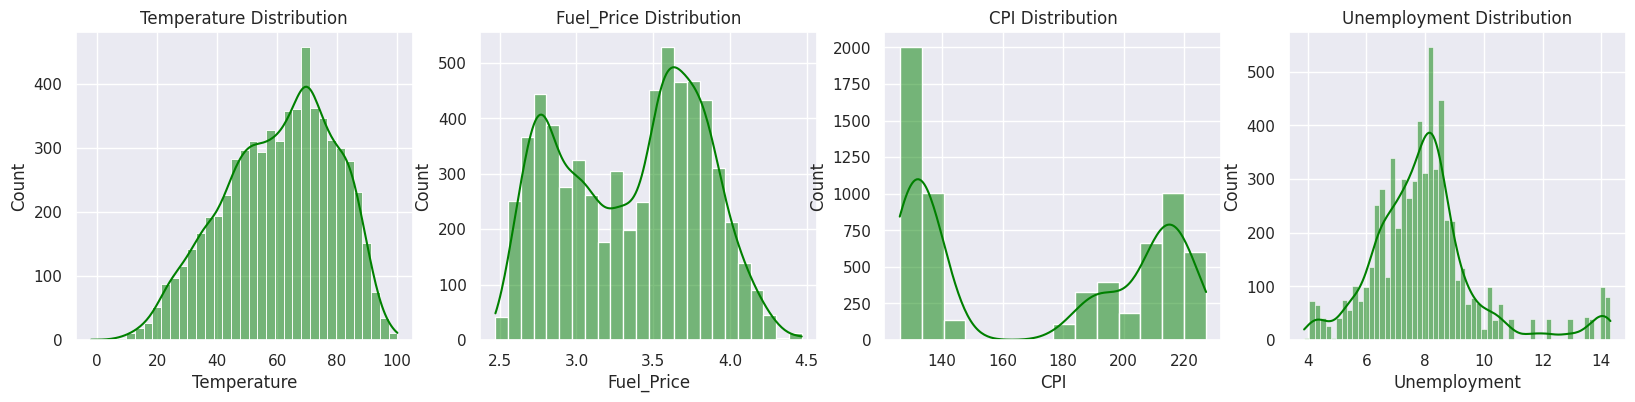

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.histplot(df,
                 x=col,
                 ax=ax[i],
                 kde=True,
                 color = 'green'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()

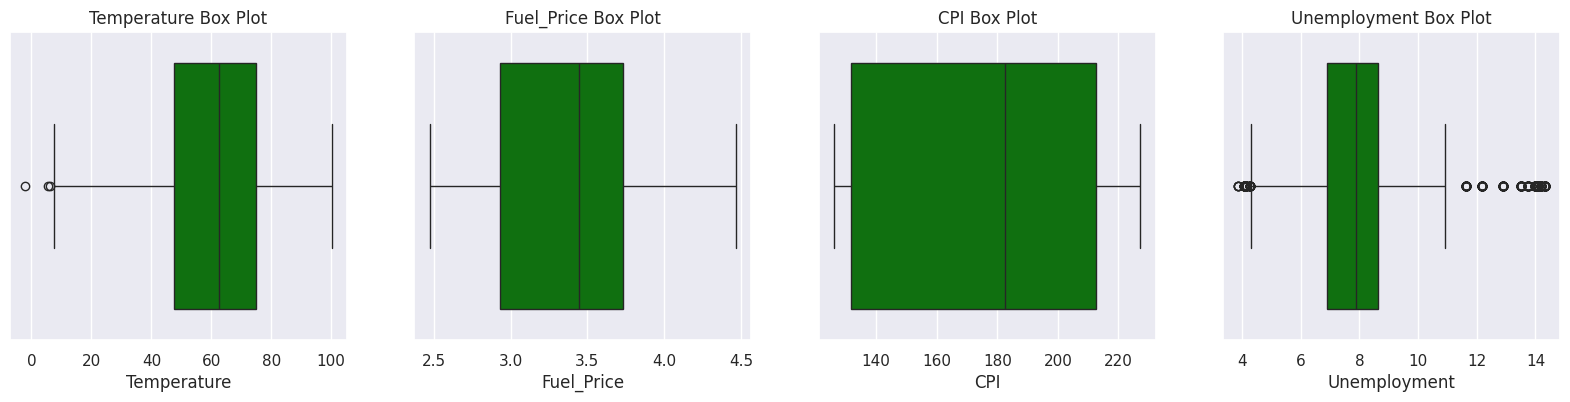

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.boxplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} Box Plot')
fig.show()

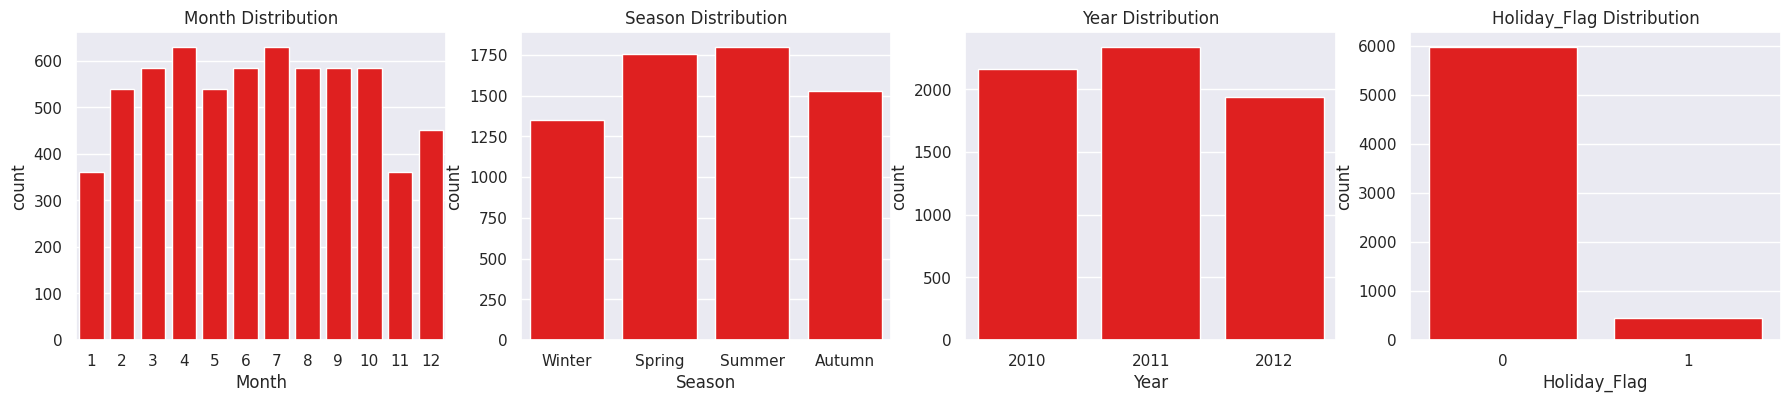

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.countplot(df,
                 x=col,
                 ax=ax[i],
                 color = 'Red'
                )
    ax[i].set_title(f'{col} Distribution')
fig.show()

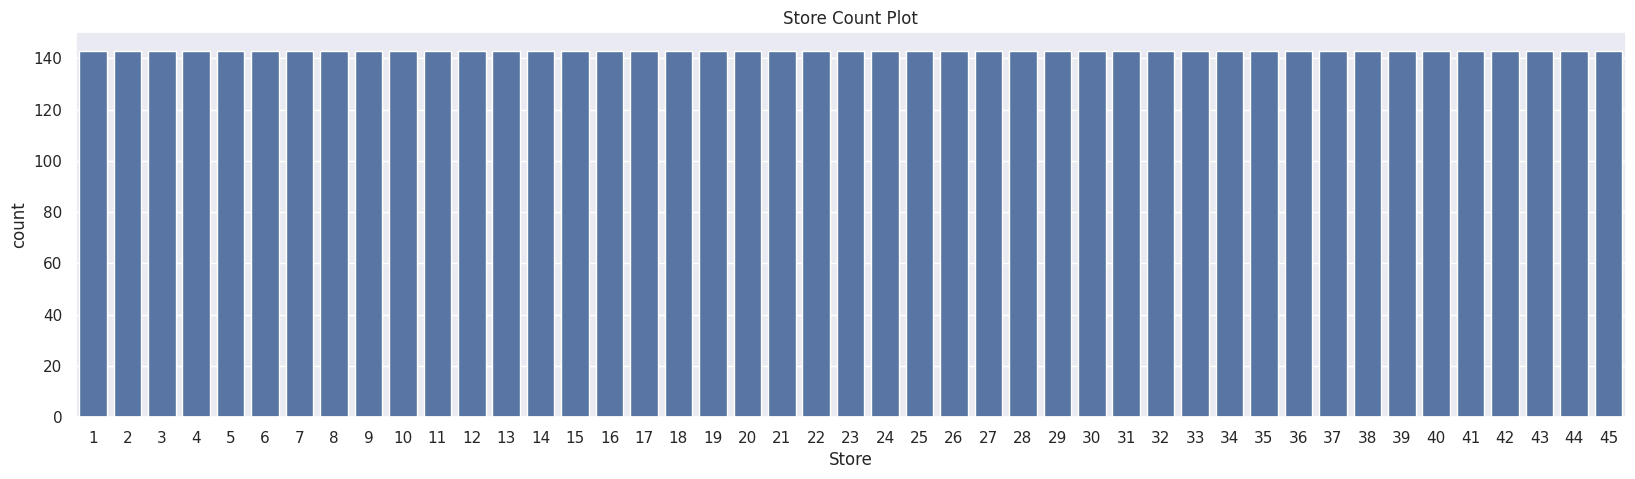

In [ ]:
plt.figure(figsize=(20,5))
sns.countplot(df,x='Store');
plt.title('Store Count Plot');

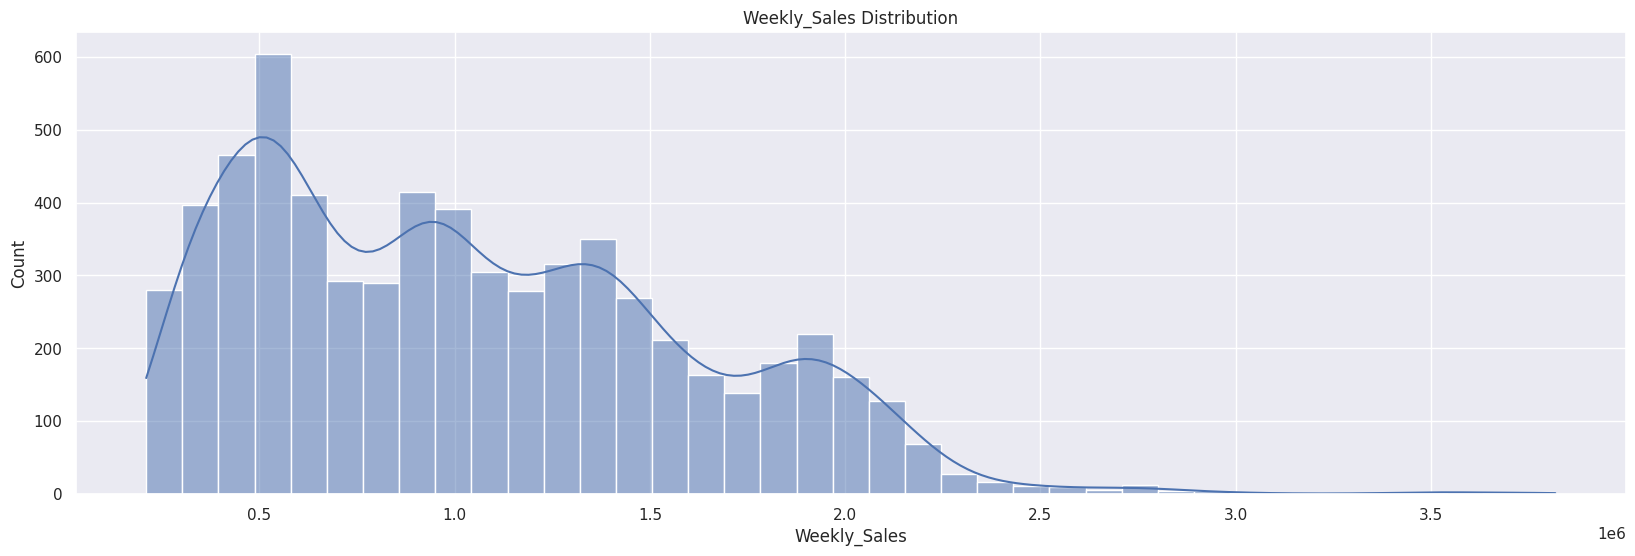

In [ ]:
plt.figure(figsize=(20,6))
sns.histplot(x=df['Weekly_Sales'],kde=True);
plt.title('Weekly_Sales Distribution');

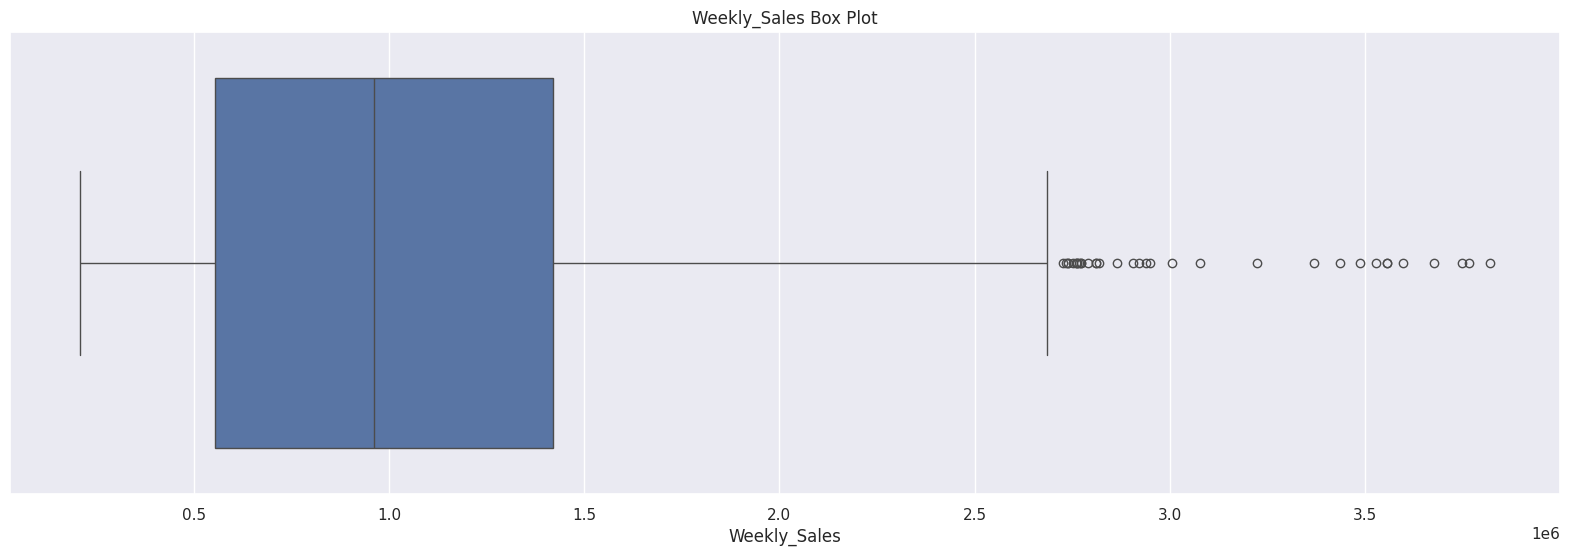

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x=df['Weekly_Sales']);
plt.title('Weekly_Sales Box Plot');


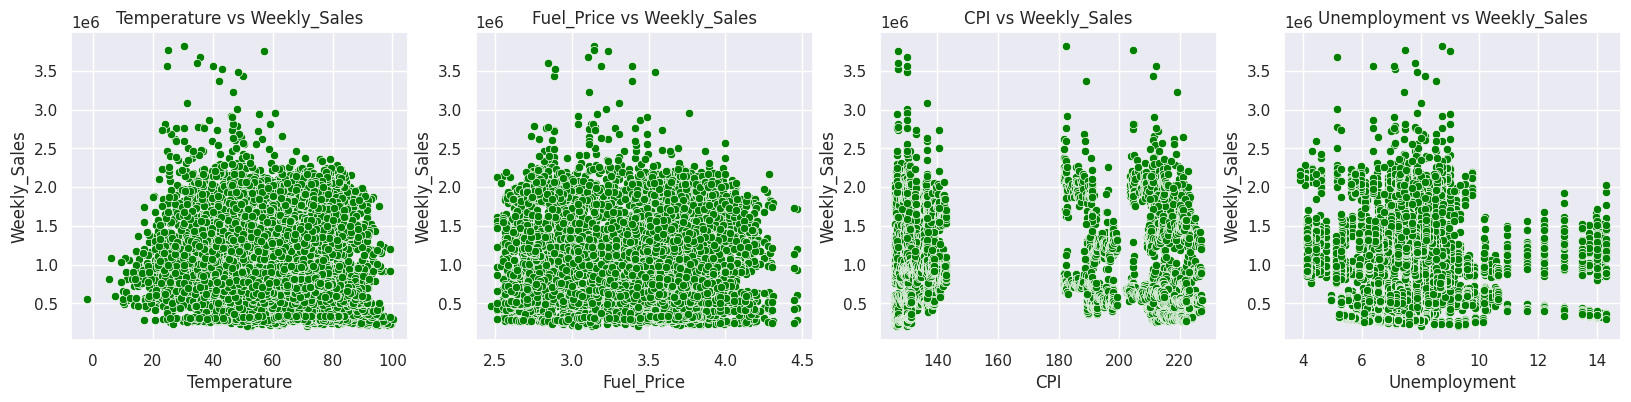

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(20,4))
cols = ['Temperature','Fuel_Price','CPI','Unemployment']
for i,col in enumerate(cols):
    sns.scatterplot(df,
                 y='Weekly_Sales',x=col,
                 ax=ax[i],
                 color = 'green'
                )
    ax[i].set_title(f'{col} vs Weekly_Sales')
fig.show()

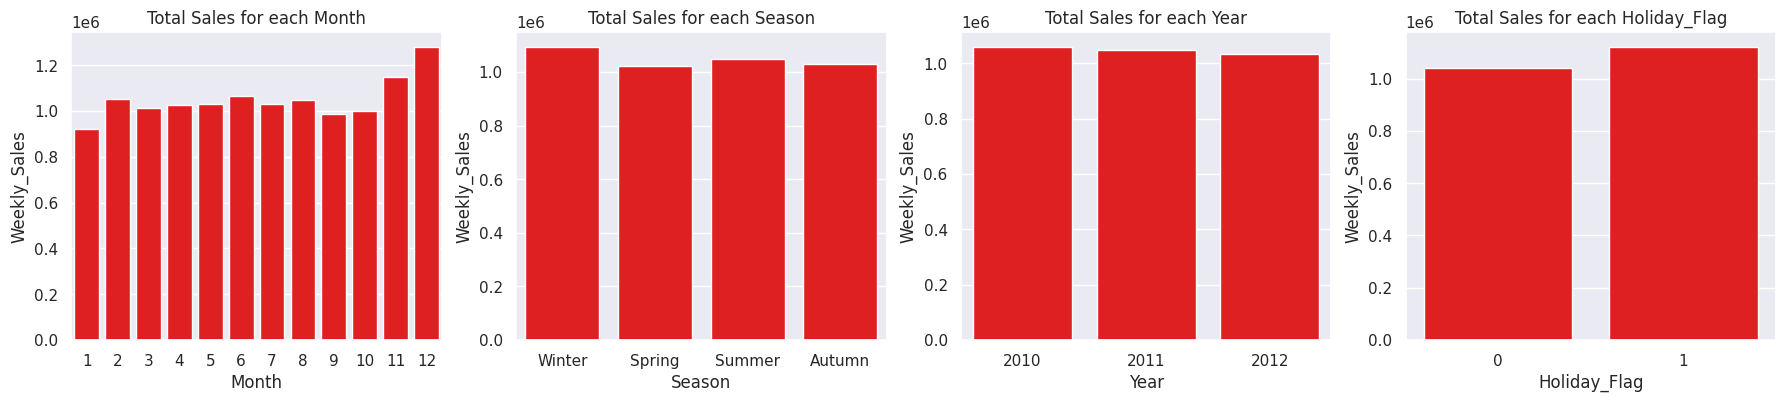

In [ ]:
fig , ax = plt.subplots(1,4,figsize=(22,4))
cols = ['Month','Season','Year','Holiday_Flag']
for i,col in enumerate(cols):
    sns.barplot(df,
                 x=col,y='Weekly_Sales',
                 ax=ax[i],
                 errorbar=None,
                 color='Red'
                )
    ax[i].set_title(f'Total Sales for each {col}')
fig.show()

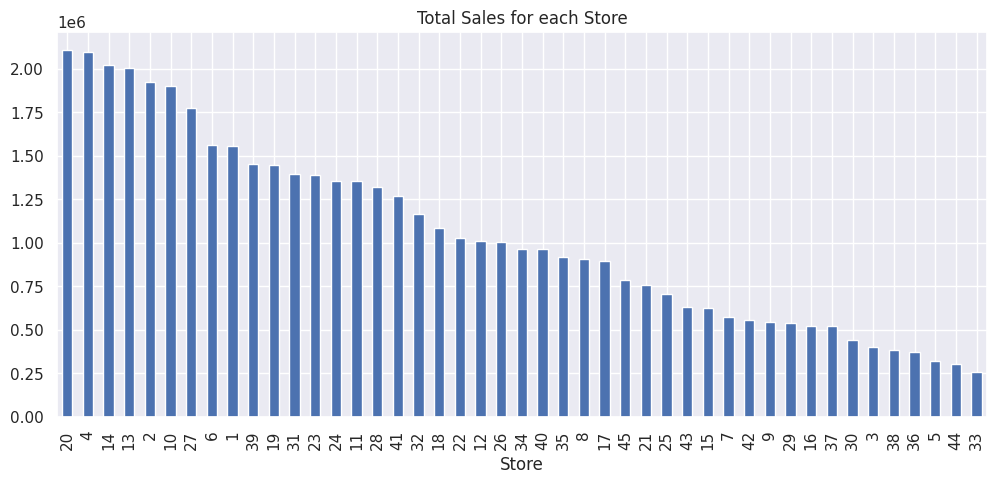

In [ ]:
plt.figure(figsize=(12,5))
df.groupby('Store')['Weekly_Sales'].mean().sort_values(ascending=False).plot(kind='bar');
plt.title('Total Sales for each Store');

In [23]:
df['Store'] = df['Store'].astype('object')

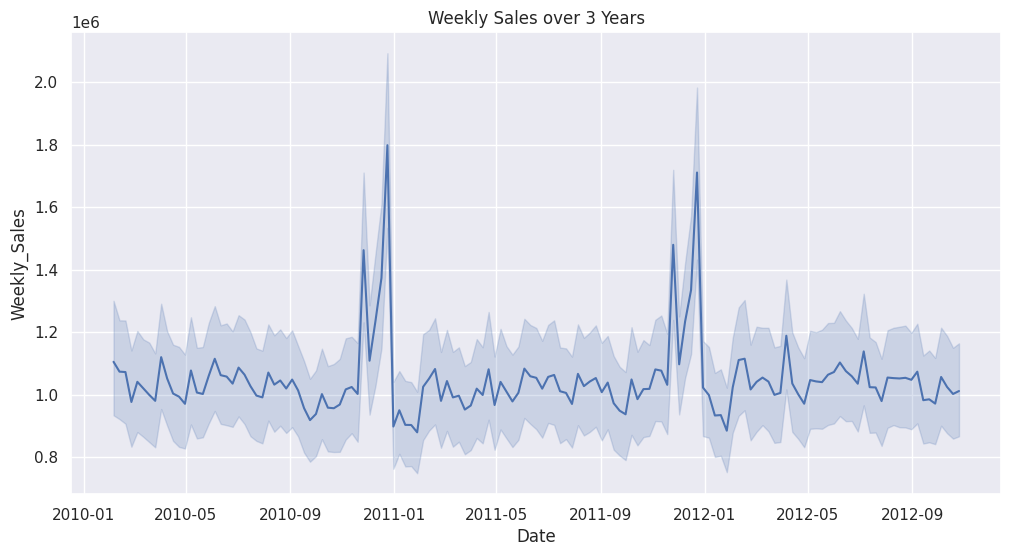

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(x=df["Date"],y=df['Weekly_Sales']);
plt.title('Weekly Sales over 3 Years');

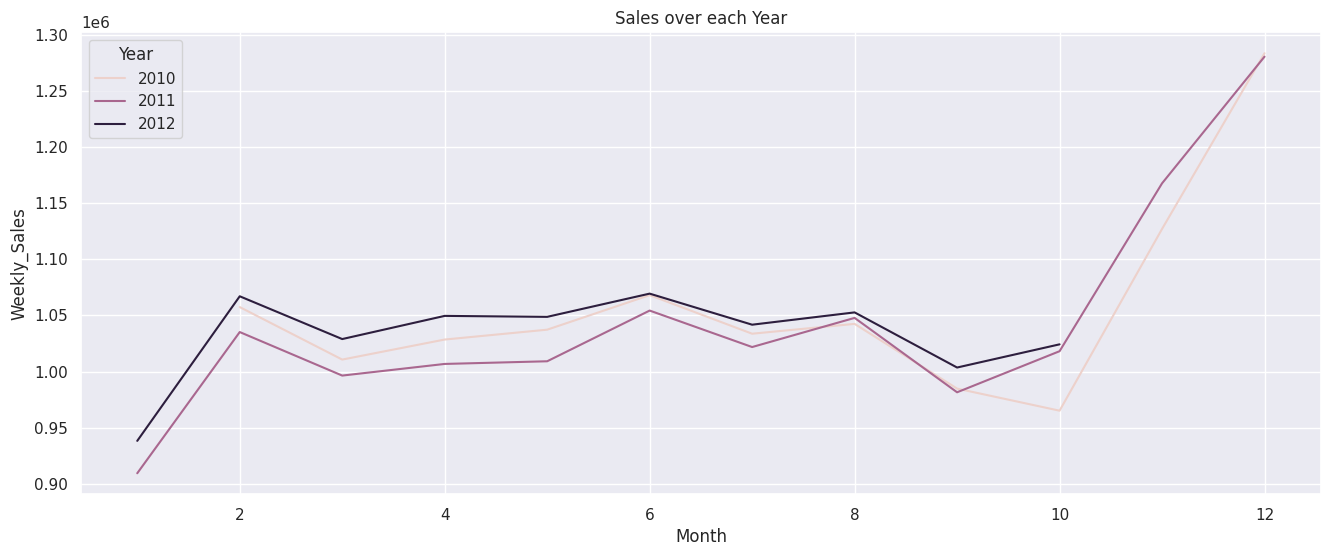

In [ ]:
plt.figure(figsize=(16,6))
sns.lineplot(x=df["Month"],y=df['Weekly_Sales'],hue=df['Year'],ci=None);
plt.title('Sales over each Year');

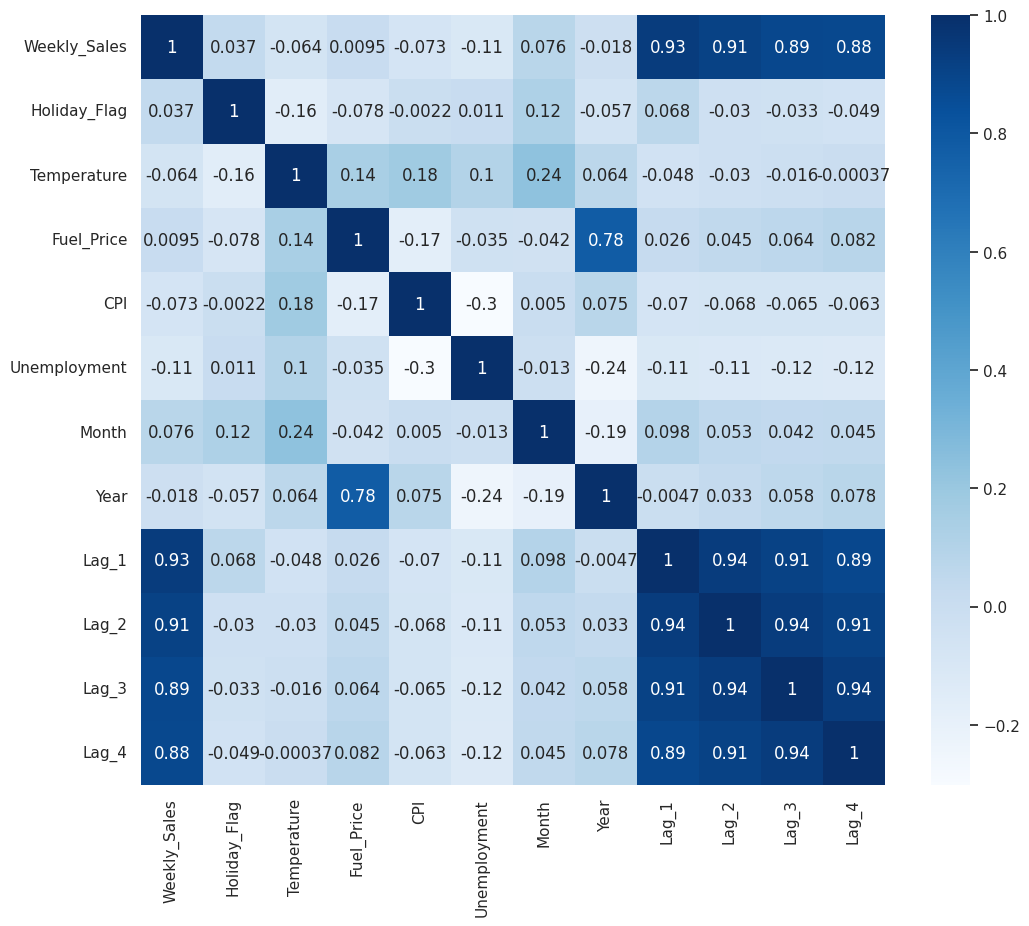

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True),cmap='Blues',annot=True);

In [24]:
num_vars = ['Temperature','Fuel_Price','CPI','Unemployment','Weekly_Sales','Lag_1','Lag_2','Lag_3','Lag_4']

# scaling numerical variables
sc = StandardScaler()
df[num_vars] = sc.fit_transform(df[num_vars])

# encoding categorical features
encoder = BinaryEncoder(cols=['Store','Season'])
df = encoder.fit_transform(df)

In [25]:
df.to_csv('clean_Walmart.csv', index=False)

In [26]:
df_clean = pd.read_csv('clean_Walmart.csv')

In [27]:
df_clean.head(5)

,Store_0,Store_1,Store_2,Store_3,Store_4,Store_5,Date,Weekly_Sales,Holiday_Flag,Temperature,...,Unemployment,Month,Year,Season_0,Season_1,Season_2,Lag_1,Lag_2,Lag_3,Lag_4
0,0,0,0,0,0,1,2010-02-05,1.057420,0,-0.995136,...,0.056964,2,2010,0,0,1,-1.826402,-1.798349,-1.771203,-1.744944
1,0,0,0,0,0,1,2010-02-12,1.054348,1,-1.201170,...,0.056964,2,2010,0,0,1,1.060488,-1.798349,-1.771203,-1.744944
2,0,0,0,0,0,1,2010-02-19,1.001206,0,-1.124178,...,0.056964,2,2010,0,0,1,1.057444,1.063497,-1.771203,-1.744944
3,0,0,0,0,0,1,2010-02-26,0.642828,0,-0.760907,...,0.056964,2,2010,0,0,1,1.004772,1.060478,1.067142,-1.744944
4,0,0,0,0,0,1,2010-03-05,0.899914,0,-0.767955,...,0.056964,3,2010,0,1,0,0.649568,1.008264,1.064149,1.071619


In [28]:
features = df.columns.drop(['Weekly_Sales','Date','Year'])
target = 'Weekly_Sales'

X = df[features]
y = df[target]

X_train , X_test , y_train , y_test = train_test_split(X,y,random_state=42 ,  test_size=0.2)